In [2994]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import seaborn as sns
import talib 
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from matplotlib.colors import ListedColormap
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression



In [2995]:
startdate = '2016-01-1'
enddate= '2021-12-31'
scaler = MinMaxScaler()

In [2996]:
dji = pdr.get_data_yahoo('^DJI', start=startdate, end=enddate)
dji_norm = pd.DataFrame(scaler.fit_transform(dji), columns=dji.columns)
n225 = pdr.get_data_yahoo("^N225", start=startdate, end=enddate)
n225_norm = pd.DataFrame(scaler.fit_transform(n225), columns=n225.columns)
hsi = pdr.get_data_yahoo("^HSI", start=startdate, end=enddate)
hsi_norm = pd.DataFrame(scaler.fit_transform(hsi), columns=hsi.columns)
sse = pdr.get_data_yahoo("000001.SS", start=startdate, end=enddate)
sse_norm = pd.DataFrame(scaler.fit_transform(sse), columns=sse.columns)


<h1>Dow Jones Industrial Average</h1>

<h2>Feature Selection</h2>

In [2997]:
dji['Future Close'] = dji['Close'].shift(-1)
dji

,High,Low,Open,Close,Volume,Adj Close,Future Close
Date,,,,,,,
2015-12-31,17590.660156,17421.160156,17590.660156,17425.029297,93690000,17425.029297,17148.939453
2016-01-04,17405.480469,16957.630859,17405.480469,17148.939453,148060000,17148.939453,17158.660156
2016-01-05,17195.839844,17038.609375,17147.500000,17158.660156,105750000,17158.660156,16906.509766
2016-01-06,17154.830078,16817.619141,17154.830078,16906.509766,120250000,16906.509766,16514.099609
2016-01-07,16888.359375,16463.630859,16888.359375,16514.099609,176240000,16514.099609,16346.450195
...,...,...,...,...,...,...,...
2021-11-29,35287.910156,34895.890625,35017.710938,35135.941406,416040000,35135.941406,34483.718750
2021-11-30,35056.988281,34424.441406,35056.988281,34483.718750,678800000,34483.718750,34022.039062
2021-12-01,35004.640625,34006.980469,34678.941406,34022.039062,496000000,34022.039062,34639.789062


In [2998]:
def computeTarget(present_price, future_price):
    score = (( future_price - present_price ) / present_price ) * 100
    target = []
    for i in score:
        if i > 0.01:
            target.append(1)
        elif i <= 0.01:
            target.append(0)
        else:
            target.append(0)
    return target
# 1 = up, 0 = down

In [2999]:

target = computeTarget(dji['Close'], dji['Future Close'])

dji['Target'] = target


In [3000]:
close = dji['Close']
high = dji['High']
low = dji['Low']
open = dji['Open']
volume  = dji['Volume']

In [3001]:
dji_ti = pd.DataFrame()
dji_ti['SMA20'] = talib.SMA(close, timeperiod=20)
dji_ti['SMA50'] = talib.SMA(close, timeperiod=50)
dji_ti['SMA200'] = talib.SMA(close, timeperiod=200)
dji_ti['EMA'] = talib.EMA(close, timeperiod=14)
dji_ti['OBV'] = talib.OBV(close, volume)
dji_ti['RSI14'] = talib.RSI(close, timeperiod=14)
dji_ti['ADX'] = talib.ADX(high, low, close, timeperiod=14)
dji_ti['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
dji_ti['aroondown'], dji_ti['aroonup'] = talib.AROON(high, low, timeperiod=14)
dji_ti['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
dji_ti['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
dji_ti['BOP'] = talib.BOP(open, high, low, close)
dji_ti['CCI'] = talib.CCI(high, low, close, timeperiod=14)
dji_ti['CMO'] = talib.CMO(close, timeperiod=14)
dji_ti['DX'] = talib.DX(high, low, close, timeperiod=14)
dji_ti['macd'],dji_ti['macdsignal'],dji_ti['macdhist'] = talib.MACD(close, fastperiod = 12, slowperiod=26, signalperiod=9)
dji_ti['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
dji_ti['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
dji_ti['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
dji_ti['MOM'] = talib.MOM(close, timeperiod=14)
dji_ti['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
dji_ti['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
dji_ti['PPO'] = talib.PPO(close, fastperiod=12, slowperiod=26, matype=0)
dji_ti['ROC'] = talib.ROC(close, timeperiod=10)
dji_ti['ROCP'] = talib.ROCP(close, timeperiod=10)
dji_ti['ROCR'] = talib.ROCR(close, timeperiod=10)
dji_ti['ROCR100'] = talib.ROCR100(close, timeperiod=10)
dji_ti['slowk'], dji_ti['slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowd_period=3, slowd_matype=0)
dji_ti['fastk'], dji_ti['fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
dji_ti['TRIX'] = talib.TRIX(close, timeperiod=30)
dji_ti['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
dji_ti['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)
dji_ti['Target'] = dji['Target']
dji_ti['Close'] = dji['Close']
dji_ti['Re Target'] = dji['Future Close']
dji_ti

,SMA20,SMA50,SMA200,EMA,OBV,RSI14,ADX,ADXR,aroondown,aroonup,...,slowk,slowd,fastk,fastd,TRIX,ULTOSC,WILLR,Target,Close,Re Target
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-31,NaN,NaN,NaN,NaN,9.369000e+07,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,17425.029297,17148.939453
2016-01-04,NaN,NaN,NaN,NaN,-5.437000e+07,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,17148.939453,17158.660156
2016-01-05,NaN,NaN,NaN,NaN,5.138000e+07,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,17158.660156,16906.509766
2016-01-06,NaN,NaN,NaN,NaN,-6.887000e+07,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,16906.509766,16514.099609
2016-01-07,NaN,NaN,NaN,NaN,-2.451100e+08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,16514.099609,16346.450195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-29,35916.813281,35272.351797,34334.093301,35657.982416,4.010637e+10,39.845233,20.966969,23.406884,92.857143,0.000000,...,36.407362,38.419346,32.727682,36.407362,0.058300,39.725168,-76.838692,0,35135.941406,34483.718750
2021-11-30,35845.307227,35282.616797,34348.898145,35501.413927,3.942757e+10,31.663054,23.173511,24.323333,100.000000,0.000000,...,16.528354,31.024955,4.183068,16.528354,0.056232,32.270423,-96.916121,0,34483.718750,34022.039062
2021-12-01,35743.777734,35284.660781,34360.943242,35304.163945,3.893157e+10,27.377423,25.744965,25.230877,100.000000,0.000000,...,12.579611,21.838442,0.828083,12.579611,0.053016,26.865407,-99.348008,1,34022.039062,34639.789062


In [3002]:
dji_target = dji_ti.tail(1)
dji_target
dji_ti = dji_ti.dropna()

In [3003]:
def selectFeatures(df, target):
    #Split the features and target data
    #select the first 13 columns as features
    X = df.drop(target, axis=1)  # Feature Matrix
    #Select the last column for target 
    Y = df[target]               # Target Variable

    #Build a logistic regression model 
    model = LinearRegression()
    #Define RFE 
    rfe = RFE(model)
    #Use RFE to select the top 5 features 
    fit = rfe.fit(X, Y)

    #Create a dataframe for the results 
    df_RFE_results = []
    for i in range(X.shape[1]):
        df_RFE_results.append(
            {      
                'Feature_names': X.columns[i],
                'Selected':  rfe.support_[i],
                'RFE_ranking':  rfe.ranking_[i],
            }
        )

    df_RFE_results = pd.DataFrame(df_RFE_results)
    df_RFE_results.index.name='Columns'
    ti = []
    for index, row in df_RFE_results.iterrows():
        if row['Selected'] == True:
            ti.append(row['Feature_names']) 
    return ti

In [3004]:
dji_features = selectFeatures(dji_ti,'Target')
dji_features.remove('Re Target')
dji_features.remove('Close')
dji_features

['ADX',
 'ADXR',
 'aroondown',
 'APO',
 'BOP',
 'CMO',
 'DX',
 'MFI',
 'MINUS_DI',
 'PLUS_DI',
 'PPO',
 'ROC',
 'ROCR100',
 'slowd',
 'TRIX',
 'ULTOSC',
 'WILLR']

In [3005]:
from sklearn.model_selection import train_test_split
X = dji_ti.loc[:, dji_features].values
#X = dji_ti.loc[:, ['CCI', 'DX', 'MINUS_DI', 'PLUS_DM', 'slowd']].values
y = dji_ti.loc[:, ['Target']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [3006]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [3007]:
# def visualize(title, xlabel, ylabel, classifier, X_test, y_test):
#     X_set, y_set = X_test, y_test
#     X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
#                          np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
#     plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
#                  alpha = 0.75, cmap = ListedColormap(('lightblue', 'cornsilk')))
#     plt.xlim(X1.min(), X1.max())
#     plt.ylim(X2.min(), X2.max())

#     for i, j in enumerate(np.unique(y_set)):
#         plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], label = j)

#     plt.title(title)
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.legend()
#     plt.show()

<h2>Decision Tree</h2>

In [3008]:
# Decision Tree Classifier: Create and Train the model
#
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [3009]:
# Prediction
#
y_pred = dtc.predict(X_test)  #Accuracy
y_pred

array([1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1])

In [3010]:
# Look at the actual y_test
#
#y_test


In [3011]:
from sklearn import metrics
cla = "classification"
reg = "regression"
def evaluate(task, y_test, y_pred):
    evaluate = []
    if task == cla:
        evaluate.append(metrics.accuracy_score(y_test, y_pred))
        evaluate.append(metrics.confusion_matrix(y_test, y_pred))
        evaluate.append(metrics.f1_score(y_test, y_pred))
        evaluate.append(metrics.precision_score(y_test, y_pred))
        evaluate.append(metrics.recall_score(y_test, y_pred))
        evaluate.append(metrics.roc_auc_score(y_test, y_pred))
    elif task == reg:
        evaluate.append(metrics.mean_squared_error(y_test, y_pred, squared=False))
        evaluate.append(metrics.r2_score(y_test, y_pred))
    return evaluate


In [3012]:
def printEval(task, evaluation):
    if task == cla:
        print("Accuracy Score: ", evaluation[0])
        print("Confusion Matrix: \n", evaluation[1])
        print("F1 Score: ", evaluation[2])
        print("Precision Score: ", evaluation[3])
        print("Recall score: ", evaluation[4])
        print("Area Under Curve score: ", evaluation[5])
    elif task == reg:
        print("Mean Squared Error: ", evaluation[0])
        print("Adjusted R squared", evaluation[1])

In [3013]:
dctEval = evaluate(cla, y_test, y_pred)
printEval(cla, dctEval)


Accuracy Score:  0.4671814671814672
Confusion Matrix: 
 [[40 72]
 [66 81]]
F1 Score:  0.54
Precision Score:  0.5294117647058824
Recall score:  0.5510204081632653
Area Under Curve score:  0.4540816326530612


<h2>Random Forest</h2>

In [3014]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [3015]:
forest = RandomForestClassifier(n_estimators = 1000, random_state = 42, max_depth=2)
forest.fit(X_train, y_train)

/var/folders/_t/ffqnjnx55t7_d2v9hx5smxm00000gn/T/ipykernel_1139/3312196032.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train, y_train)


RandomForestClassifier(max_depth=2, n_estimators=1000, random_state=42)

In [3016]:
# Prediction
#
y_pred = forest.predict(X_test)  #Accuracy
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [3017]:
forestEval = evaluate(cla, y_test, y_pred)
printEval(cla, forestEval)

Accuracy Score:  0.5675675675675675
Confusion Matrix: 
 [[  0 112]
 [  0 147]]
F1 Score:  0.7241379310344828
Precision Score:  0.5675675675675675
Recall score:  1.0
Area Under Curve score:  0.5


<h2>Logistic Regression</h2>

In [3018]:
# Logistic Regression Classifier: Create and Train the model
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()
logistic.fit(X_train, y_train)

/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [3019]:
# Prediction
y_pred = logistic.predict(X_test)  #Accuracy
y_pred

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [3020]:
# Look at the actual y_test
#y_test

In [3021]:
logisticEval = evaluate(cla, y_test, y_pred)
printEval(cla, logisticEval)

Accuracy Score:  0.5444015444015444
Confusion Matrix: 
 [[ 18  94]
 [ 24 123]]
F1 Score:  0.6758241758241758
Precision Score:  0.5668202764976958
Recall score:  0.8367346938775511
Area Under Curve score:  0.4987244897959184


<h2>XGBoost</h2>

In [3022]:
from xgboost import XGBClassifier
from numpy import loadtxt
from sklearn.metrics import accuracy_score

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

[17:56:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [3023]:
y_pred = xgb.predict(X_test)  #Accuracy
y_pred

array([1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1])

In [3024]:
#y_test

In [3025]:
xgbEval = evaluate(cla, y_test, y_pred)
printEval(cla, xgbEval)

Accuracy Score:  0.5019305019305019
Confusion Matrix: 
 [[36 76]
 [53 94]]
F1 Score:  0.5930599369085174
Precision Score:  0.5529411764705883
Recall score:  0.6394557823129252
Area Under Curve score:  0.4804421768707483


<h2>Linear Regression</h2>

In [3026]:
dji_ti['Re Target'] = dji['Future Close']

/var/folders/_t/ffqnjnx55t7_d2v9hx5smxm00000gn/T/ipykernel_1139/935387594.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dji_ti['Re Target'] = dji['Future Close']


In [3027]:
# dji_target = dji_ti.tail(1)
# dji_target
# dji_ti = dji_ti.dropna()

In [3028]:
dji_refeatures = selectFeatures(dji_ti,'Re Target')
dji_refeatures.remove('Target')
dji_refeatures.remove('Close')
dji_refeatures

['EMA',
 'RSI14',
 'ADXR',
 'APO',
 'BOP',
 'CMO',
 'DX',
 'macdhist',
 'MFI',
 'MINUS_DI',
 'PLUS_DI',
 'PPO',
 'ROC',
 'slowd',
 'fastk',
 'TRIX',
 'WILLR']

In [3029]:
from sklearn.model_selection import train_test_split
X = dji_ti.loc[:, dji_refeatures].values
#X = dji_ti.loc[:, ['CCI', 'DX', 'MINUS_DI', 'PLUS_DM', 'slowd']].values
y = dji_ti.loc[:, ['Re Target']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [3030]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [3031]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
from sklearn import metrics

In [3032]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [3033]:
y_pred = lr.predict(X_test)
print(y_pred)

[[25492.30002395]
 [25933.76088839]
 [34438.7362519 ]
 [22471.1743985 ]
 [26702.26646053]
 [25617.09088108]
 [35028.85110632]
 [26626.50408745]
 [28394.25088899]
 [21543.46000671]
 [35397.62519699]
 [24655.11934957]
 [33861.53239898]
 [29752.11136526]
 [25355.06003078]
 [33849.55661078]
 [29264.71077499]
 [21452.10674113]
 [26142.86607791]
 [26601.00707154]
 [25399.78403726]
 [20042.64480856]
 [28426.44917947]
 [35275.48352331]
 [18078.72426069]
 [20976.32315917]
 [26376.26999805]
 [24928.36728858]
 [24731.10563009]
 [22355.91198285]
 [19041.65153933]
 [30427.95651922]
 [25068.16363291]
 [24074.76710077]
 [36179.41653737]
 [34987.45451203]
 [35905.29115142]
 [25819.8723023 ]
 [27258.78897081]
 [28553.64421612]
 [30008.23168493]
 [21114.21928385]
 [19629.99155616]
 [34019.48986296]
 [28061.50205935]
 [35230.96558871]
 [26636.67630028]
 [26528.97964436]
 [23546.51565454]
 [25444.75243678]
 [31523.48350315]
 [25046.51460716]
 [19814.4642121 ]
 [24519.7516268 ]
 [25299.89377875]
 [35048.79

In [3034]:
dframe = pd.DataFrame({'Actual':y_test.flatten(),'predicted':y_pred.flatten()})

In [3035]:
print('Slope:', lr.coef_)
print('Intercept:', lr.intercept_)

Slope: [[ 4.38092397e+03 -1.35327789e+01 -6.56111610e+00  4.54807241e+02
   1.67105596e+01 -1.35327789e+01 -3.86557856e+01  2.39250312e+02
  -5.79302413e+01 -6.32670188e+01  7.13044348e+01 -3.98053384e+02
   1.11242942e+02 -2.71648602e+01  1.36917306e+02  6.77305456e+01
   9.04172469e-01]]
Intercept: [26311.33766207]


In [3036]:
def plotReg(title, X, y, ti, features, model):
    X_target = ti.loc[:, features].values
    y_target = ti.loc[:, ['Re Target']].values
    X_target = sc.transform(X_target)
    # Plot outputs
    fig = plt.figure(figsize=(13,6))
    plt.plot(X,y, color="black", label="Future Close Price")
    plt.plot(X[-180:],y[-180:], color="green", label="Actual")
    plt.plot(X[-180:], model.predict(X_target), color="orange", label="predicted")
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

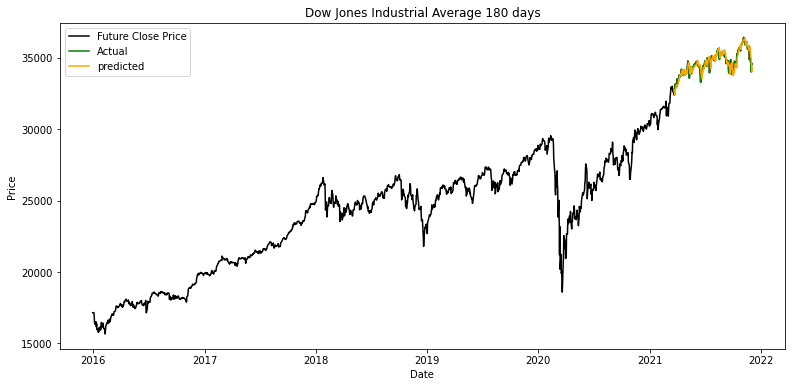

In [3037]:
plotReg('Dow Jones Industrial Average 180 days', dji.index, dji[['Future Close']], dji_ti.iloc[-180:], dji_refeatures, lr)

In [3038]:
lrEval = evaluate(reg, y_test, y_pred)
printEval(reg, lrEval)

Mean Squared Error:  367.76999303927886
Adjusted R squared 0.9928898912634773


<h2>Polynomial Regression</h2>

In [3039]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
degree=2
pr=make_pipeline(PolynomialFeatures(degree),LinearRegression())
pr.fit(X_train,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [3040]:
y_pred = pr.predict(X_test)  #Accuracy
#y_pred

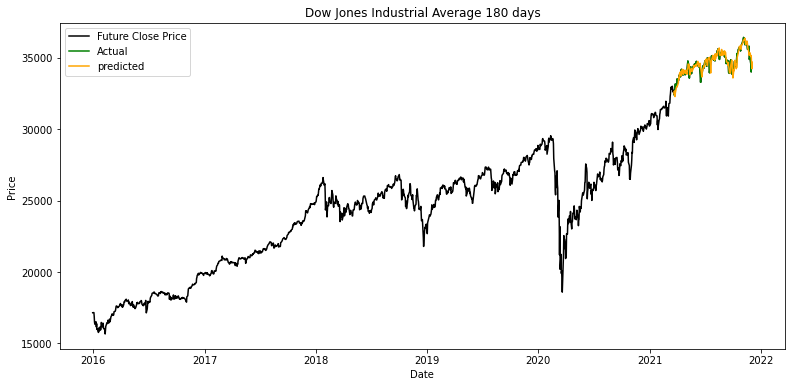

In [3041]:
plotReg('Dow Jones Industrial Average 180 days', dji.index, dji[['Future Close']], dji_ti.iloc[-180:], dji_refeatures, pr)

In [3042]:
prEval = evaluate(reg, y_test, y_pred)
printEval(reg, prEval)

Mean Squared Error:  377.257894410767
Adjusted R squared 0.9925182992679793


In [3043]:
def finalEvaluate(pred):
    down = pred.count(0)
    up = pred.count(1)
    upText = "The model suggests that you should sell"
    downText = "The model suggests that you should buy"
    print(pred)
    if up > down:
        print(upText)
        return True
    elif up < down:
        print(downText)
        return True
    else:
        return False

In [3044]:
def regPredict(classifier, pred, target):
    predict = classifier.predict(pred)
    tg = target['Close'].values[0]
    if predict[0] > tg:
        return 1
    else:
        return 0


In [3045]:
from sklearn.preprocessing import normalize
def finalPredict(target, target_features, retarget_features, dctEvaluation, forestEvaluation, logisticEvaluation, xgbEvaluation, lrEvaluation, prEvaluation):
    X = target.loc[:, target_features].values
    X_test = sc.transform(X)
    reX = target.loc[:, retarget_features].values
    reX_test = sc.transform(reX)
    dctE = dctEvaluation.copy()
    forestE = forestEvaluation.copy()
    logisticE = logisticEvaluation.copy()
    xgbE = xgbEvaluation.copy()
    lrE = lrEvaluation.copy()
    prE = prEvaluation.copy()
    evaluation = []
    evaluation.append(dctE[0])
    evaluation.append(forestE[0])
    evaluation.append(logisticE[0])
    evaluation.append(xgbE[0])
    evaluation.append(lrE[1])
    evaluation.append(prE[1])
    pred = []
    pred.append(dtc.predict(X_test)[0])
    pred.append(forest.predict(X_test)[0])
    pred.append(logistic.predict(X_test)[0])
    pred.append(xgb.predict(X_test)[0])
    pred.append(regPredict(lr, reX_test, target))
    pred.append(regPredict(pr, reX_test, target))
    final = finalEvaluate(pred)
    if final == False:
        min_value = min(evaluation)
        min_index = evaluation.index(min_value)
        pred.pop(min_index)
        finalEvaluate(pred)


In [3046]:
finalPredict(dji_target, dji_features,dji_refeatures, dctEval, forestEval, logisticEval, xgbEval, lrEval, prEval)


[1, 0, 1, 1, 0, 0]
[0, 1, 1, 0, 0]
The model suggests that you should buy


<h1>Nikkei 225 Stock Average</h1>

<h2>Feature Selection</h2>

In [3047]:
n225['Future Close'] = n225['Close'].shift(-1)
n225

,High,Low,Open,Close,Volume,Adj Close,Future Close
Date,,,,,,,
2016-01-04,18951.119141,18394.429688,18818.580078,18450.980469,140200000.0,18450.980469,18374.000000
2016-01-05,18547.380859,18327.519531,18398.759766,18374.000000,132300000.0,18374.000000,18191.320312
2016-01-06,18469.380859,18064.300781,18410.570312,18191.320312,142200000.0,18191.320312,17767.339844
2016-01-07,18172.039062,17767.339844,18139.769531,17767.339844,168000000.0,17767.339844,17697.960938
2016-01-08,17975.310547,17509.640625,17562.230469,17697.960938,184300000.0,17697.960938,17218.960938
...,...,...,...,...,...,...,...
2021-11-29,28776.339844,28187.119141,28337.960938,28283.919922,85900000.0,28283.919922,27821.759766
2021-11-30,28718.699219,27819.140625,28611.730469,27821.759766,140700000.0,27821.759766,27935.619141
2021-12-01,28106.300781,27594.009766,27866.730469,27935.619141,80900000.0,27935.619141,27753.369141


In [3048]:
target = computeTarget(n225['Close'], n225['Future Close'])

n225['Target'] = target

In [3049]:
close = n225['Close']
high = n225['High']
low = n225['Low']
open = n225['Open']
volume  = n225['Volume']

In [3050]:
n225_ti = pd.DataFrame()
n225_ti['SMA20'] = talib.SMA(close, timeperiod=20)
n225_ti['SMA50'] = talib.SMA(close, timeperiod=50)
n225_ti['SMA200'] = talib.SMA(close, timeperiod=200)
n225_ti['EMA'] = talib.EMA(close, timeperiod=14)
n225_ti['OBV'] = talib.OBV(close, volume)
n225_ti['RSI14'] = talib.RSI(close, timeperiod=14)
n225_ti['ADX'] = talib.ADX(high, low, close, timeperiod=14)
n225_ti['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
n225_ti['aroondown'], n225_ti['aroonup'] = talib.AROON(high, low, timeperiod=14)
n225_ti['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
n225_ti['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
n225_ti['BOP'] = talib.BOP(open, high, low, close)
n225_ti['CCI'] = talib.CCI(high, low, close, timeperiod=14)
n225_ti['CMO'] = talib.CMO(close, timeperiod=14)
n225_ti['DX'] = talib.DX(high, low, close, timeperiod=14)
n225_ti['macd'],n225_ti['macdsignal'],n225_ti['macdhist'] = talib.MACD(close, fastperiod = 12, slowperiod=26, signalperiod=9)
n225_ti['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
n225_ti['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
n225_ti['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
n225_ti['MOM'] = talib.MOM(close, timeperiod=14)
n225_ti['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
n225_ti['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
n225_ti['PPO'] = talib.PPO(close, fastperiod=12, slowperiod=26, matype=0)
n225_ti['ROC'] = talib.ROC(close, timeperiod=10)
n225_ti['ROCP'] = talib.ROCP(close, timeperiod=10)
n225_ti['ROCR'] = talib.ROCR(close, timeperiod=10)
n225_ti['ROCR100'] = talib.ROCR100(close, timeperiod=10)
n225_ti['slowk'], n225_ti['slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowd_period=3, slowd_matype=0)
n225_ti['fastk'], n225_ti['fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
n225_ti['TRIX'] = talib.TRIX(close, timeperiod=30)
n225_ti['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
n225_ti['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)
n225_ti['Target'] = n225['Target']
n225_ti['Close'] = n225['Close']
n225_ti['Re Target'] = n225['Future Close']
n225_ti

,SMA20,SMA50,SMA200,EMA,OBV,RSI14,ADX,ADXR,aroondown,aroonup,...,slowk,slowd,fastk,fastd,TRIX,ULTOSC,WILLR,Target,Close,Re Target
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,NaN,NaN,NaN,NaN,1.402000e+08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,18450.980469,18374.000000
2016-01-05,NaN,NaN,NaN,NaN,7.900000e+06,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,18374.000000,18191.320312
2016-01-06,NaN,NaN,NaN,NaN,-1.343000e+08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,18191.320312,17767.339844
2016-01-07,NaN,NaN,NaN,NaN,-3.023000e+08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,17767.339844,17697.960938
2016-01-08,NaN,NaN,NaN,NaN,-4.866000e+08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,17697.960938,17218.960938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-29,29424.154883,29207.691016,28945.626270,29258.019304,5.590400e+09,36.087929,14.019772,13.770901,100.000000,42.857143,...,22.126310,29.701132,5.977677,22.126310,0.043856,39.061709,-94.542778,0,28283.919922,27821.759766
2021-11-30,29370.608398,29153.891992,28943.025322,29066.518032,5.449700e+09,31.862883,16.441484,14.666264,100.000000,35.714286,...,6.090439,17.547172,0.135083,6.090439,0.041502,31.087620,-99.877712,1,27821.759766,27935.619141
2021-12-01,29285.035352,29106.137578,28938.807471,28915.731513,5.530600e+09,33.915601,18.932162,15.663407,100.000000,28.571429,...,7.799032,12.005260,17.284336,7.799032,0.038143,33.765736,-85.567345,0,27935.619141,27753.369141


In [3051]:

n225_target = n225_ti.tail(1)

In [3052]:
n225_ti = n225_ti.dropna()
n225_features = selectFeatures(n225_ti, 'Target')
n225_features.remove('Re Target')
n225_features.remove('Close')
n225_features

['ADX',
 'ADXR',
 'aroondown',
 'aroonup',
 'BOP',
 'CCI',
 'MINUS_DI',
 'PLUS_DI',
 'PPO',
 'ROC',
 'ROCR100',
 'slowk',
 'slowd',
 'fastd',
 'TRIX',
 'ULTOSC',
 'WILLR']

In [3053]:
X = n225_ti.loc[:, n225_features].values
#X = dji_ti.loc[:, ['CCI', 'DX', 'MINUS_DI', 'PLUS_DM', 'slowd']].values
y = n225_ti.loc[:, ['Target']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [3054]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

<h2>Decision Tree</h2>

In [3055]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [3056]:
# Prediction
#
y_pred = dtc.predict(X_test)  #Accuracy
y_pred

array([0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0])

In [3057]:
# Look at the actual y_test
#
y_test

array([[0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [3058]:
dctEval = evaluate(cla, y_test, y_pred)
printEval(cla, dctEval)

Accuracy Score:  0.444
Confusion Matrix: 
 [[53 69]
 [70 58]]
F1 Score:  0.4549019607843137
Precision Score:  0.4566929133858268
Recall score:  0.453125
Area Under Curve score:  0.4437756147540984


<h2>Random Forest</h2>

In [3059]:
forest = RandomForestClassifier(n_estimators = 1000, random_state = 43, max_depth=4, min_samples_split=2 )
forest.fit(X_train, y_train)

/var/folders/_t/ffqnjnx55t7_d2v9hx5smxm00000gn/T/ipykernel_1139/2696115339.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train, y_train)


RandomForestClassifier(max_depth=4, n_estimators=1000, random_state=43)

In [3060]:
# Prediction
#
y_pred = forest.predict(X_test)  #Accuracy
y_pred

/Users/skooter/Library/Python/3.9/lib/python/site-packages/IPython/core/displayhook.py:275: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


array([0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1])

In [3061]:
#y_test

In [3062]:
forestEval = evaluate(cla, y_test, y_pred)
printEval(cla, forestEval)

Accuracy Score:  0.48
Confusion Matrix: 
 [[55 67]
 [63 65]]
F1 Score:  0.5
Precision Score:  0.49242424242424243
Recall score:  0.5078125
Area Under Curve score:  0.47931608606557374


<h2>Logistic Regression</h2>

In [3063]:
# Logistic Regression Classifier: Create and Train the model
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [3064]:
# Prediction
y_pred = logistic.predict(X_test)  #Accuracy
y_pred

array([0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 1])

In [3065]:
# Look at the actual y_test
#y_test

In [3066]:
logisticEval = evaluate(cla, y_test, y_pred)
printEval(cla, logisticEval)

Accuracy Score:  0.52
Confusion Matrix: 
 [[49 73]
 [47 81]]
F1 Score:  0.574468085106383
Precision Score:  0.525974025974026
Recall score:  0.6328125
Area Under Curve score:  0.5172259221311475


<h2>XGBoost</h2>

In [3067]:
from xgboost import XGBClassifier
from numpy import loadtxt
from sklearn.metrics import accuracy_score

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[17:56:37] WARNING: /

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [3068]:
y_pred = xgb.predict(X_test)  #Accuracy
y_pred

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1])

In [3069]:
#y_test

In [3070]:
xgbEval = evaluate(cla, y_test, y_pred)
printEval(cla, xgbEval)

Accuracy Score:  0.456
Confusion Matrix: 
 [[49 73]
 [63 65]]
F1 Score:  0.4887218045112782
Precision Score:  0.47101449275362317
Recall score:  0.5078125
Area Under Curve score:  0.4547259221311476


<h2>Linear Regress</h2>

In [3071]:
n225_refeatures = selectFeatures(n225_ti,'Re Target')
n225_refeatures.remove('Target')
n225_refeatures.remove('Close')
n225_refeatures

['ADX',
 'ADXR',
 'aroondown',
 'aroonup',
 'BOP',
 'CMO',
 'DX',
 'MINUS_DI',
 'PLUS_DI',
 'PPO',
 'ROC',
 'ROCR100',
 'slowk',
 'fastk',
 'fastd',
 'TRIX',
 'ULTOSC']

In [3072]:
from sklearn.model_selection import train_test_split
X = n225_ti.loc[:, n225_refeatures].values
y = n225_ti.loc[:, ['Re Target']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [3073]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [3074]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
from sklearn import metrics

In [3075]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [3076]:
y_pred = lr.predict(X_test)
#print(y_pred)

In [3077]:
dframe = pd.DataFrame({'Actual':y_test.flatten(),'predicted':y_pred.flatten()})

In [3078]:
print('Slope:', lr.coef_)
print('Intercept:', lr.intercept_)

Slope: [[-4.71084314e+02  2.48632188e+02 -2.39865423e+02 -1.96709073e+02
   2.99044280e+02 -2.24145666e+03  2.75952723e+02 -1.40583596e+03
   5.25252250e+02  4.74810176e+02  8.59458500e+16 -8.59458500e+16
   3.32141300e+15  1.97491937e+02 -3.32141300e+15  8.40695311e+02
  -1.02412814e+03]]
Intercept: [24322.75764951]


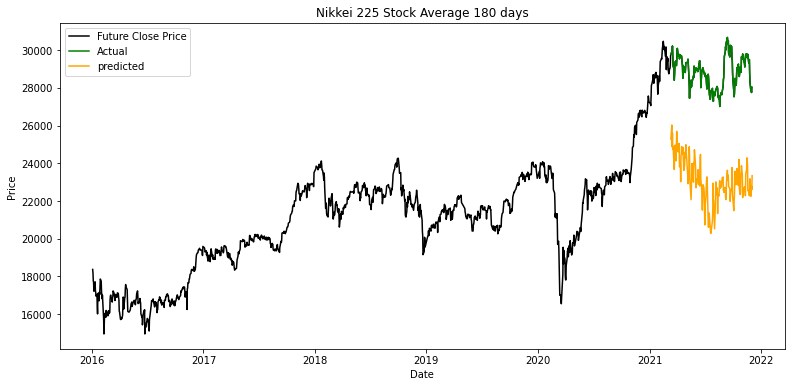

In [3079]:
plotReg('Nikkei 225 Stock Average 180 days', n225.index, n225[['Future Close']], n225_ti.iloc[-180:], n225_refeatures, lr)

In [3080]:
lrEval = evaluate(reg, y_test, y_pred)
printEval(reg, lrEval)

Mean Squared Error:  3102.447148179311
Adjusted R squared 0.13959069147859393


<h2>Polynomial Regression</h2>

In [3081]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
degree=2
pr=make_pipeline(PolynomialFeatures(degree),LinearRegression())
pr.fit(X_train,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [3082]:
y_pred = pr.predict(X_test)  #Accuracy
#y_pred

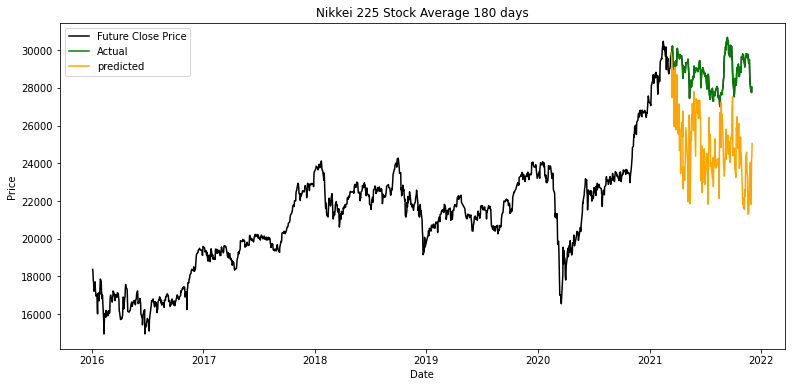

In [3083]:
plotReg('Nikkei 225 Stock Average 180 days', n225.index, n225[['Future Close']], n225_ti.iloc[-180:], n225_refeatures, pr)

In [3084]:
gsEval = evaluate(reg, y_test, y_pred)
printEval(reg, gsEval)

Mean Squared Error:  2638.312056023757
Adjusted R squared 0.3777733032025189


In [3085]:
finalPredict(dji_target, dji_features,dji_refeatures, dctEval, forestEval, logisticEval, xgbEval, lrEval, prEval)


[0, 1, 1, 1, 1, 0]
The model suggests that you should sell


<h1>Heng Seng Index</h1>

<h2>Feature Selection</h2>

In [3086]:
hsi['Future Close'] = hsi['Close'].shift(-1)
hsi

,High,Low,Open,Close,Volume,Adj Close,Future Close
Date,,,,,,,
2016-01-04,21794.839844,21227.609375,21782.619141,21327.119141,1.712095e+09,21327.119141,21188.720703
2016-01-05,21452.740234,21095.900391,21318.689453,21188.720703,1.484745e+09,21188.720703,20980.810547
2016-01-06,21199.619141,20947.300781,21142.630859,20980.810547,1.651083e+09,20980.810547,20333.339844
2016-01-07,20826.439453,20323.970703,20772.599609,20333.339844,2.982004e+09,20333.339844,20453.710938
2016-01-08,20596.419922,20324.619141,20491.880859,20453.710938,2.078133e+09,20453.710938,19888.500000
...,...,...,...,...,...,...,...
2021-11-29,24134.320312,23774.310547,23910.490234,23852.240234,1.741008e+09,23852.240234,23475.259766
2021-11-30,23888.369141,23175.369141,23782.859375,23475.259766,3.344858e+09,23475.259766,23658.919922
2021-12-01,23864.300781,23537.650391,23595.570312,23658.919922,2.118635e+09,23658.919922,23788.929688


In [3087]:
target = computeTarget(hsi['Close'], hsi['Future Close'])

hsi['Target'] = target


In [3088]:
close = hsi['Close']
high = hsi['High']
low = hsi['Low']
open = hsi['Open']
volume  = hsi['Volume']

In [3089]:
hsi_ti = pd.DataFrame()
hsi_ti['SMA20'] = talib.SMA(close, timeperiod=20)
hsi_ti['SMA50'] = talib.SMA(close, timeperiod=50)
hsi_ti['SMA200'] = talib.SMA(close, timeperiod=200)
hsi_ti['EMA'] = talib.EMA(close, timeperiod=14)
hsi_ti['OBV'] = talib.OBV(close, volume)
hsi_ti['RSI14'] = talib.RSI(close, timeperiod=14)
hsi_ti['ADX'] = talib.ADX(high, low, close, timeperiod=14)
hsi_ti['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
hsi_ti['aroondown'], hsi_ti['aroonup'] = talib.AROON(high, low, timeperiod=14)
hsi_ti['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
hsi_ti['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
hsi_ti['BOP'] = talib.BOP(open, high, low, close)
hsi_ti['CCI'] = talib.CCI(high, low, close, timeperiod=14)
hsi_ti['CMO'] = talib.CMO(close, timeperiod=14)
hsi_ti['DX'] = talib.DX(high, low, close, timeperiod=14)
hsi_ti['macd'],hsi_ti['macdsignal'],hsi_ti['macdhist'] = talib.MACD(close, fastperiod = 12, slowperiod=26, signalperiod=9)
hsi_ti['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
hsi_ti['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
hsi_ti['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
hsi_ti['MOM'] = talib.MOM(close, timeperiod=14)
hsi_ti['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
hsi_ti['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
hsi_ti['PPO'] = talib.PPO(close, fastperiod=12, slowperiod=26, matype=0)
hsi_ti['ROC'] = talib.ROC(close, timeperiod=10)
hsi_ti['ROCP'] = talib.ROCP(close, timeperiod=10)
hsi_ti['ROCR'] = talib.ROCR(close, timeperiod=10)
hsi_ti['ROCR100'] = talib.ROCR100(close, timeperiod=10)
hsi_ti['slowk'], hsi_ti['slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowd_period=3, slowd_matype=0)
hsi_ti['fastk'], hsi_ti['fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
hsi_ti['TRIX'] = talib.TRIX(close, timeperiod=30)
hsi_ti['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
hsi_ti['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)
hsi_ti['Target'] = hsi['Target']
hsi_ti['Close'] = hsi['Close']
hsi_ti['Re Target'] = hsi['Future Close']
hsi_ti

,SMA20,SMA50,SMA200,EMA,OBV,RSI14,ADX,ADXR,aroondown,aroonup,...,slowk,slowd,fastk,fastd,TRIX,ULTOSC,WILLR,Target,Close,Re Target
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,NaN,NaN,NaN,NaN,1.712095e+09,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,21327.119141,21188.720703
2016-01-05,NaN,NaN,NaN,NaN,2.273497e+08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,21188.720703,20980.810547
2016-01-06,NaN,NaN,NaN,NaN,-1.423734e+09,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,20980.810547,20333.339844
2016-01-07,NaN,NaN,NaN,NaN,-4.405738e+09,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,20333.339844,20453.710938
2016-01-08,NaN,NaN,NaN,NaN,-2.327604e+09,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,20453.710938,19888.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-29,24972.746094,24993.557461,27310.298682,24780.603467,1.830117e+11,29.872744,18.157605,16.725154,100.000000,35.714286,...,15.184520,17.046495,7.234342,15.184520,-0.058054,37.122164,-96.048992,0,23852.240234,23475.259766
2021-11-30,24891.525586,24962.398438,27281.231582,24606.557641,1.796668e+11,26.337965,20.745865,17.735988,100.000000,28.571429,...,8.961841,13.965130,17.891526,8.961841,-0.060435,35.699137,-88.337193,1,23475.259766,23658.919922
2021-12-01,24823.234082,24942.219844,27252.928828,24480.205945,1.817854e+11,30.643761,23.149249,18.413873,92.857143,21.428571,...,18.530248,14.225536,30.464877,18.530248,-0.063597,35.681700,-81.194613,1,23658.919922,23788.929688


In [3090]:
hsi_target = hsi_ti.tail(1)

In [3091]:
hsi_ti = hsi_ti.dropna()
hsi_features = selectFeatures(hsi_ti,'Target')
hsi_features.remove('Re Target')
hsi_features.remove('Close')
hsi_features

['RSI14',
 'ADX',
 'ADXR',
 'aroonup',
 'BOP',
 'CMO',
 'DX',
 'MINUS_DI',
 'PLUS_DI',
 'PPO',
 'ROC',
 'ROCR100',
 'slowk',
 'fastk',
 'fastd',
 'TRIX',
 'ULTOSC']

In [3092]:
X = hsi_ti.loc[:, hsi_features].values
#X = dji_ti.loc[:, ['CCI', 'DX', 'MINUS_DI', 'PLUS_DM', 'slowd']].values
y = hsi_ti.loc[:, ['Target']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [3093]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

<h2>Decision Tree</h2>

In [3094]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [3095]:
# Prediction
#
y_pred = dtc.predict(X_test)  #Accuracy
y_pred

array([1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1])

In [3096]:
# Look at the actual y_test
#
y_test

array([[0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
    

In [3097]:
dctEval = evaluate(cla, y_test, y_pred)
printEval(cla, dctEval)

Accuracy Score:  0.4603174603174603
Confusion Matrix: 
 [[53 67]
 [69 63]]
F1 Score:  0.4809160305343511
Precision Score:  0.4846153846153846
Recall score:  0.4772727272727273
Area Under Curve score:  0.459469696969697


<h2>Random Forest</h2>

In [3098]:
forest = RandomForestClassifier(n_estimators = 1000, random_state = 40, max_depth=2 )
forest.fit(X_train, y_train)

/var/folders/_t/ffqnjnx55t7_d2v9hx5smxm00000gn/T/ipykernel_1139/33020272.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train, y_train)


RandomForestClassifier(max_depth=2, n_estimators=1000, random_state=40)

In [3099]:
# Prediction
#
y_pred = forest.predict(X_test)  #Accuracy
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [3100]:
forestEval = evaluate(cla, y_test, y_pred)
printEval(cla, forestEval)

Accuracy Score:  0.503968253968254
Confusion Matrix: 
 [[  7 113]
 [ 12 120]]
F1 Score:  0.6575342465753424
Precision Score:  0.5150214592274678
Recall score:  0.9090909090909091
Area Under Curve score:  0.4837121212121212


<h2>Logistic Regression</h2>

In [3101]:
# Logistic Regression Classifier: Create and Train the model
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [3102]:
# Prediction
y_pred = dtc.predict(X_test)  #Accuracy
y_pred

array([1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1])

In [3103]:
# Look at the actual y_test
#y_test

In [3104]:
logisticEval = evaluate(cla, y_test, y_pred)
printEval(cla, logisticEval)

Accuracy Score:  0.4603174603174603
Confusion Matrix: 
 [[53 67]
 [69 63]]
F1 Score:  0.4809160305343511
Precision Score:  0.4846153846153846
Recall score:  0.4772727272727273
Area Under Curve score:  0.459469696969697


<h2>XGBoost</h2>

In [3105]:
from xgboost import XGBClassifier
from numpy import loadtxt
from sklearn.metrics import accuracy_score

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

[17:56:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [3106]:
y_pred = xgb.predict(X_test)  #Accuracy
y_pred

array([0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 1])

In [3107]:
#y_test

In [3108]:
xgbEval = evaluate(cla, y_test, y_pred)
printEval(cla, xgbEval)

Accuracy Score:  0.5158730158730159
Confusion Matrix: 
 [[57 63]
 [59 73]]
F1 Score:  0.544776119402985
Precision Score:  0.5367647058823529
Recall score:  0.553030303030303
Area Under Curve score:  0.5140151515151515


<h2>Linear Regression</h2>

In [3109]:
hsi_refeatures = selectFeatures(hsi_ti,'Re Target')
hsi_refeatures.remove('Target')
hsi_refeatures.remove('Close')
hsi_refeatures

['RSI14',
 'ADXR',
 'BOP',
 'CMO',
 'DX',
 'MINUS_DI',
 'PLUS_DI',
 'PPO',
 'ROC',
 'ROCR100',
 'slowk',
 'slowd',
 'fastk',
 'fastd',
 'TRIX',
 'ULTOSC',
 'WILLR']

In [3110]:
from sklearn.model_selection import train_test_split
X = hsi_ti.loc[:, hsi_refeatures].values
#X = dji_ti.loc[:, ['CCI', 'DX', 'MINUS_DI', 'PLUS_DM', 'slowd']].values
y = hsi_ti.loc[:, ['Re Target']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

In [3111]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [3112]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
from sklearn import metrics

In [3113]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [3114]:
y_pred = lr.predict(X_test)
print(y_pred)

[[27053.93431287]
 [27149.33008181]
 [27436.49986339]
 [27549.82114365]
 [27346.28702759]
 [27566.19637898]
 [27712.19831317]
 [27530.81218223]
 [27333.89816155]
 [27741.10459649]
 [27672.12977197]
 [27616.1842687 ]
 [27587.40726061]
 [27473.70440931]
 [27641.26505272]
 [28008.66581074]
 [28128.73153124]
 [28001.43532446]
 [27885.12302797]
 [28020.6251263 ]
 [28178.16475999]
 [28231.60030073]
 [28253.9216264 ]
 [28379.87593563]
 [28186.08739127]
 [28367.69407194]
 [28310.57679604]
 [28329.42444081]
 [28503.50457125]
 [28565.00279784]
 [28187.94256544]
 [28521.56077662]
 [28291.47346564]
 [28215.17942707]
 [28188.85760436]
 [28426.37845642]
 [28494.36003145]
 [28707.64088099]
 [28613.39409997]
 [29162.67947078]
 [29638.70054619]
 [29614.67590037]
 [29479.10858115]
 [29255.59883088]
 [29029.51096076]
 [28950.55401822]
 [28902.46010654]
 [28720.61443081]
 [28808.83398858]
 [28756.90560088]
 [28294.95714428]
 [28781.74013757]
 [29022.49488077]
 [29395.85566563]
 [29338.35434799]
 [29429.44

In [3115]:
dframe = pd.DataFrame({'Actual':y_test.flatten(),'predicted':y_pred.flatten()})

In [3116]:
print('Slope:', lr.coef_)
print('Intercept:', lr.intercept_)

Slope: [[-3.62150876e+13  6.11093750e+01  1.08061800e+02  3.62150876e+13
  -9.03734233e+01 -3.98281091e+02  4.26590099e+02  4.46993843e+02
  -1.27781320e+15  1.27781320e+15 -1.58806960e+13 -1.00795918e+02
   8.03299352e+01  1.58806960e+13  1.04611958e+03  3.87592053e+02
   3.59578793e+02]]
Intercept: [26787.57131905]


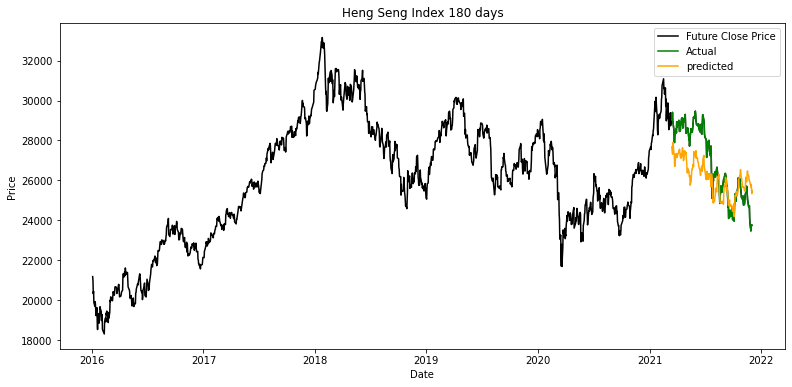

In [3117]:
plotReg('Heng Seng Index 180 days', hsi.index, hsi[['Future Close']], hsi_ti.iloc[-180:], hsi_refeatures, lr)

In [3118]:
lrEval = evaluate(reg, y_test, y_pred)
printEval(reg, lrEval)

Mean Squared Error:  1275.8241297324182
Adjusted R squared 0.4909704356191683


<h2>Polynomial Regression</h2>

In [3119]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
degree=2
pr=make_pipeline(PolynomialFeatures(degree),LinearRegression())
pr.fit(X_train,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [3120]:
y_pred = pr.predict(X_test)  #Accuracy
y_pred

array([[25560.55236816],
       [24929.55187988],
       [23715.53512573],
       [25025.5088501 ],
       [25607.56338501],
       [26058.71035767],
       [26963.79953003],
       [26488.85195923],
       [24582.84869385],
       [26119.34539795],
       [25738.81195068],
       [24978.40567017],
       [24981.49658203],
       [26074.24401855],
       [26848.15283203],
       [27974.67501831],
       [27953.99588013],
       [27060.31494141],
       [28155.29962158],
       [28276.86090088],
       [27869.33480835],
       [28493.75018311],
       [29024.53884888],
       [27593.42373657],
       [26984.2883606 ],
       [26885.55371094],
       [27128.89761353],
       [27158.06646729],
       [28279.42959595],
       [28235.61172485],
       [27399.34667969],
       [28418.62088013],
       [28720.26596069],
       [29358.92404175],
       [29565.65866089],
       [30309.07131958],
       [32626.23147583],
       [34839.45547485],
       [35156.15826416],
       [36783.96121216],


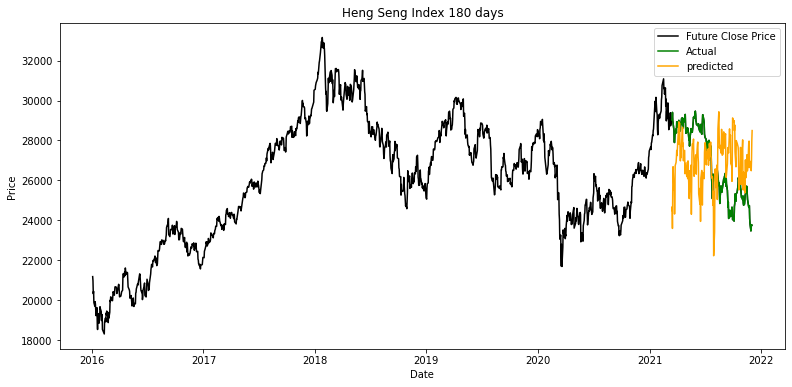

In [3121]:
plotReg('Heng Seng Index 180 days', hsi.index, hsi[['Future Close']], hsi_ti.iloc[-180:], hsi_refeatures, pr)

In [3122]:
gsEval = evaluate(reg, y_test, y_pred)
printEval(reg, gsEval)

Mean Squared Error:  2434.6246780129927
Adjusted R squared -0.8536401299809722


In [3123]:
finalPredict(dji_target, dji_features,dji_refeatures, dctEval, forestEval, logisticEval, xgbEval, lrEval, prEval)


[1, 1, 0, 1, 0, 1]
The model suggests that you should sell


<h1>SSE Composite Index</h1>

<h2>Feature Selection</h2>

In [3124]:
sse['Future Close'] = sse['Close'].shift(-1)
sse

,High,Low,Open,Close,Volume,Adj Close,Future Close
Date,,,,,,,
2016-01-04,3538.688965,3295.740967,3536.589111,3296.258057,184400,3296.258057,3287.710938
2016-01-05,3328.138916,3189.604980,3196.650879,3287.710938,266900,3287.710938,3361.840088
2016-01-06,3362.974121,3288.933105,3291.195068,3361.840088,238900,3361.840088,3125.001953
2016-01-07,3309.656982,3115.885010,3309.656982,3125.001953,70600,3125.001953,3186.412109
2016-01-08,3235.450928,3056.877930,3194.625000,3186.412109,286400,3186.412109,3016.704102
...,...,...,...,...,...,...,...
2021-11-29,3563.679932,3526.360107,3528.669922,3562.699951,333600,3562.699951,3563.889893
2021-11-30,3582.120117,3546.360107,3570.750000,3563.889893,349200,3563.889893,3576.889893
2021-12-01,3576.889893,3558.689941,3561.889893,3576.889893,329900,3576.889893,3573.840088


In [3125]:
target = computeTarget(sse['Close'], sse['Future Close'])

sse['Target'] = target

In [3126]:
close = sse['Close']
high = sse['High']
low = sse['Low']
open = sse['Open']
volume  = sse['Volume']

In [3127]:
sse_ti = pd.DataFrame()
sse_ti['SMA20'] = talib.SMA(close, timeperiod=20)
sse_ti['SMA50'] = talib.SMA(close, timeperiod=50)
sse_ti['SMA200'] = talib.SMA(close, timeperiod=200)
sse_ti['EMA'] = talib.EMA(close, timeperiod=14)
sse_ti['OBV'] = talib.OBV(close, volume)
sse_ti['RSI14'] = talib.RSI(close, timeperiod=14)
sse_ti['ADX'] = talib.ADX(high, low, close, timeperiod=14)
sse_ti['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
sse_ti['aroondown'], sse_ti['aroonup'] = talib.AROON(high, low, timeperiod=14)
sse_ti['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
sse_ti['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
sse_ti['BOP'] = talib.BOP(open, high, low, close)
sse_ti['CCI'] = talib.CCI(high, low, close, timeperiod=14)
sse_ti['CMO'] = talib.CMO(close, timeperiod=14)
sse_ti['DX'] = talib.DX(high, low, close, timeperiod=14)
sse_ti['macd'],sse_ti['macdsignal'],sse_ti['macdhist'] = talib.MACD(close, fastperiod = 12, slowperiod=26, signalperiod=9)
sse_ti['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
sse_ti['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
sse_ti['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
sse_ti['MOM'] = talib.MOM(close, timeperiod=14)
sse_ti['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
sse_ti['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
sse_ti['PPO'] = talib.PPO(close, fastperiod=12, slowperiod=26, matype=0)
sse_ti['ROC'] = talib.ROC(close, timeperiod=10)
sse_ti['ROCP'] = talib.ROCP(close, timeperiod=10)
sse_ti['ROCR'] = talib.ROCR(close, timeperiod=10)
sse_ti['ROCR100'] = talib.ROCR100(close, timeperiod=10)
sse_ti['slowk'], sse_ti['slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowd_period=3, slowd_matype=0)
sse_ti['fastk'], sse_ti['fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
sse_ti['TRIX'] = talib.TRIX(close, timeperiod=30)
sse_ti['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
sse_ti['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)
sse_ti['Target'] = sse['Target']
sse_ti['Close'] = sse['Close']
sse_ti['Re Target'] = sse['Future Close']
sse_ti

,SMA20,SMA50,SMA200,EMA,OBV,RSI14,ADX,ADXR,aroondown,aroonup,...,slowk,slowd,fastk,fastd,TRIX,ULTOSC,WILLR,Target,Close,Re Target
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,NaN,NaN,NaN,NaN,184400.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3296.258057,3287.710938
2016-01-05,NaN,NaN,NaN,NaN,-82500.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3287.710938,3361.840088
2016-01-06,NaN,NaN,NaN,NaN,156400.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3361.840088,3125.001953
2016-01-07,NaN,NaN,NaN,NaN,85800.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3125.001953,3186.412109
2016-01-08,NaN,NaN,NaN,NaN,372200.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3186.412109,3016.704102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-29,3537.048621,3572.031455,3526.526178,3558.156371,24524100.0,51.831473,18.346326,22.970243,7.142857,78.571429,...,48.339676,65.263526,47.580810,48.339676,-0.007703,68.169630,-25.947123,1,3562.699951,3563.889893
2021-11-30,3539.961621,3569.247051,3526.930282,3558.920841,24873300.0,52.096479,17.369247,22.381258,0.000000,71.428571,...,38.655207,49.692145,49.138835,38.655207,-0.007386,61.739004,-32.396652,1,3563.889893,3576.889893
2021-12-01,3543.879114,3566.477446,3527.288312,3561.316714,25203200.0,55.008687,16.461959,21.674837,0.000000,64.285714,...,56.033229,47.676037,71.380042,56.033229,-0.006916,61.441675,-28.837060,0,3576.889893,3573.840088


In [3128]:
sse_target = hsi_ti.tail(1)

In [3129]:
sse_ti = sse_ti.dropna()
sse_features = selectFeatures(sse_ti,'Target')
sse_features.remove('Re Target')
sse_features.remove('Close')
sse_features

['SMA20',
 'EMA',
 'RSI14',
 'ADX',
 'APO',
 'BOP',
 'CMO',
 'macdhist',
 'MINUS_DI',
 'MINUS_DM',
 'PLUS_DI',
 'PLUS_DM',
 'PPO',
 'ROC',
 'ROCR100',
 'fastd',
 'TRIX']

In [3130]:
X = sse_ti.loc[:, sse_features].values
y = sse_ti.loc[:, ['Target']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [3131]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

<h2>Decision Tree</h2>

In [3132]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [3133]:
# Prediction
#
y_pred = dtc.predict(X_test)  #Accuracy
y_pred

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0])

In [3134]:
# Look at the actual y_test
#
y_test

array([[0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
    

In [3135]:
dctEval = evaluate(cla, y_test, y_pred)
printEval(cla, dctEval)

Accuracy Score:  0.4798387096774194
Confusion Matrix: 
 [[55 68]
 [61 64]]
F1 Score:  0.4980544747081712
Precision Score:  0.48484848484848486
Recall score:  0.512
Area Under Curve score:  0.47957723577235767


<h2>Random Forest</h2>

In [3136]:
forest = RandomForestClassifier(n_estimators = 1000, random_state = 42, max_features=9)
forest.fit(X_train, y_train)

/var/folders/_t/ffqnjnx55t7_d2v9hx5smxm00000gn/T/ipykernel_1139/371548984.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train, y_train)


RandomForestClassifier(max_features=9, n_estimators=1000, random_state=42)

In [3137]:
# Prediction
#
y_pred = forest.predict(X_test)  #Accuracy
y_pred

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1])

In [3138]:
forestEval = evaluate(cla, y_test, y_pred)
printEval(cla, forestEval)

Accuracy Score:  0.5362903225806451
Confusion Matrix: 
 [[56 67]
 [48 77]]
F1 Score:  0.5724907063197027
Precision Score:  0.5347222222222222
Recall score:  0.616
Area Under Curve score:  0.5356422764227643


<h2>Logistic Regression</h2>

In [3139]:
# Logistic Regression Classifier: Create and Train the model
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [3140]:
# Prediction
y_pred = logistic.predict(X_test)  #Accuracy
y_pred

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1])

In [3141]:
# Look at the actual y_test
#y_test

In [3142]:
logisticEval = evaluate(cla, y_test, y_pred)
printEval(cla, logisticEval)

Accuracy Score:  0.5
Confusion Matrix: 
 [[38 85]
 [39 86]]
F1 Score:  0.5810810810810811
Precision Score:  0.5029239766081871
Recall score:  0.688
Area Under Curve score:  0.4984715447154472


<h2>XGBoost</h2>

In [3143]:
from xgboost import XGBClassifier
from numpy import loadtxt
from sklearn.metrics import accuracy_score

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

[17:56:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [3144]:
y_pred = xgb.predict(X_test)  #Accuracy
y_pred

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1])

In [3145]:
#y_test

In [3146]:
xgbEval = evaluate(cla, y_test, y_pred)
printEval(cla, xgbEval)

Accuracy Score:  0.532258064516129
Confusion Matrix: 
 [[64 59]
 [57 68]]
F1 Score:  0.5396825396825398
Precision Score:  0.5354330708661418
Recall score:  0.544
Area Under Curve score:  0.5321626016260163


<h2>Linear Regression</h2>

In [3147]:
sse_refeatures = selectFeatures(sse_ti,'Re Target')
sse_refeatures.remove('Target')
sse_refeatures.remove('Close')
sse_features

['SMA20',
 'EMA',
 'RSI14',
 'ADX',
 'APO',
 'BOP',
 'CMO',
 'macdhist',
 'MINUS_DI',
 'MINUS_DM',
 'PLUS_DI',
 'PLUS_DM',
 'PPO',
 'ROC',
 'ROCR100',
 'fastd',
 'TRIX']

In [3148]:
from sklearn.model_selection import train_test_split
X = sse_ti.loc[:, sse_refeatures].values
#X = dji_ti.loc[:, ['CCI', 'DX', 'MINUS_DI', 'PLUS_DM', 'slowd']].values
y = sse_ti.loc[:, ['Re Target']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

In [3149]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [3150]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
from sklearn import metrics

In [3151]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [3152]:
y_pred = lr.predict(X_test)
print(y_pred)

[[3355.43597977]
 [3399.62405513]
 [3398.49663751]
 [3441.24843045]
 [3440.11665036]
 [3431.46544222]
 [3436.73963668]
 [3403.09312747]
 [3398.96189304]
 [3362.21373484]
 [3368.69064148]
 [3334.53342725]
 [3358.68986471]
 [3351.64042621]
 [3348.19225651]
 [3396.6462584 ]
 [3382.67142148]
 [3413.19959878]
 [3343.36583867]
 [3367.64844246]
 [3345.96668971]
 [3376.73477722]
 [3375.71905127]
 [3352.04049348]
 [3386.01307796]
 [3442.38804438]
 [3472.36205389]
 [3497.05369345]
 [3522.52493787]
 [3550.64853725]
 [3550.70504934]
 [3514.0025199 ]
 [3571.47462775]
 [3569.40372314]
 [3538.33966098]
 [3538.85299004]
 [3568.73386405]
 [3538.3042636 ]
 [3555.59828738]
 [3603.22499265]
 [3588.00748975]
 [3615.07641129]
 [3560.52568139]
 [3563.16072923]
 [3504.35796709]
 [3475.68549584]
 [3493.66558401]
 [3524.19582927]
 [3509.53660303]
 [3484.69465179]
 [3483.41495644]
 [3514.52727673]
 [3587.02324573]
 [3639.23958089]
 [3676.55147724]
 [3683.7097399 ]
 [3643.47545766]
 [3633.73799625]
 [3550.0414526

In [3153]:
dframe = pd.DataFrame({'Actual':y_test.flatten(),'predicted':y_pred.flatten()})

In [3154]:
print('Slope:', lr.coef_)
print('Intercept:', lr.intercept_)

Slope: [[ 2.17816748e+02  1.77058078e+13  3.54674167e+00 -3.44978374e+01
   1.90365381e+00 -1.77058078e+13  3.79274173e+13 -3.53165718e+13
  -1.23538284e+13  4.12232813e+01 -7.27092094e+01 -3.02171408e+01
   6.64956337e+01  8.14261841e+00 -7.38090556e+14  7.38090556e+14
  -1.34374367e+01]]
Intercept: [3080.15311771]


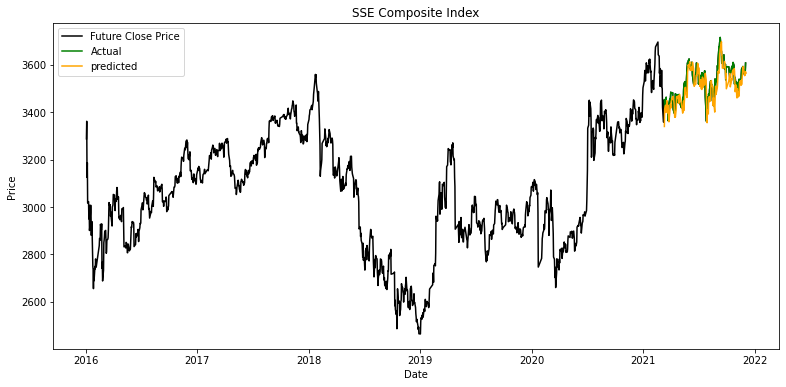

In [3155]:
plotReg('SSE Composite Index', sse.index, sse[['Future Close']], sse_ti.iloc[-180:], sse_refeatures, lr)

In [3156]:
#evaluate("reg", y_test, y_pred)

lrEval = evaluate(reg, y_test, y_pred)
printEval(reg, lrEval)

Mean Squared Error:  37.86996282079727
Adjusted R squared 0.772562130758375


<h2>Polynomial Regression</h2>

In [3157]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
degree=2
pr=make_pipeline(PolynomialFeatures(degree),LinearRegression())
pr.fit(X_train,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [3158]:
y_pred = pr.predict(X_test)  #Accuracy
y_pred

array([[3369.40893555],
       [3423.1652832 ],
       [3375.31274414],
       [3453.4777832 ],
       [3453.22583008],
       [3448.04418945],
       [3450.14282227],
       [3425.5480957 ],
       [3405.59033203],
       [3363.39233398],
       [3359.59838867],
       [3334.65844727],
       [3370.77587891],
       [3364.77856445],
       [3372.81958008],
       [3409.81298828],
       [3397.45239258],
       [3421.60522461],
       [3341.39624023],
       [3370.21435547],
       [3356.48852539],
       [3393.74047852],
       [3396.28735352],
       [3384.30737305],
       [3408.65307617],
       [3459.59399414],
       [3479.38012695],
       [3483.56567383],
       [3520.8215332 ],
       [3535.8527832 ],
       [3547.0402832 ],
       [3506.71606445],
       [3561.9230957 ],
       [3594.3605957 ],
       [3573.8527832 ],
       [3584.92504883],
       [3626.8371582 ],
       [3635.5949707 ],
       [3621.50073242],
       [3657.77026367],
       [3657.77563477],
       [3656.204

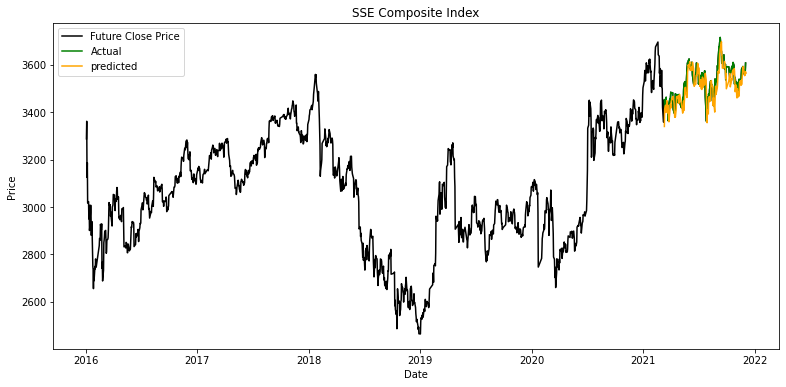

In [3159]:
plotReg('SSE Composite Index', sse.index, sse[['Future Close']], sse_ti.iloc[-180:], sse_refeatures, lr)

In [3160]:
gsEval = evaluate(reg, y_test, y_pred)
printEval(reg, gsEval)

Mean Squared Error:  47.699133039399584
Adjusted R squared 0.6391771839936817


In [3161]:
finalPredict(dji_target, dji_features,dji_refeatures, dctEval, forestEval, logisticEval, xgbEval, lrEval, prEval)



[0, 0, 1, 1, 0, 0]
The model suggests that you should buy
